# DICOM to Video


In [37]:
import pydicom
import pandas as pd

codebook = pd.read_csv('../dataset/RVENet/codebook.csv')
file_names = codebook['FileName'].values
file_format = '.dcm'

# name = file_names[0]
name = '04bddacc760e085b906324f195cf299d_0000_0000'
dicom_dir = '../dataset/RVENet/DICOM'
dcm = pydicom.dcmread(f'{dicom_dir}/{name}{file_format}')

In [44]:
print(dcm.pixel_array.shape)
dcm

(135, 708, 1016, 3)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 208
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Ultrasound Multi-frame Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.391.60366.1537271365.238.1.512
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113619.6.391
(0002, 0013) Implementation Version Name         SH: 'VIVIDE95_202.1'
(0002, 0016) Source Application Entity Title     AE: 'KA_US_VividE95'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', '', '0001', 'GEMSMULTIFRAME', 'GEMSMGCOUNT1', '', '', '', '', 'I23']
(0008, 0060) Modality                            CS: 'US'
(0008, 0070) Manufacturer

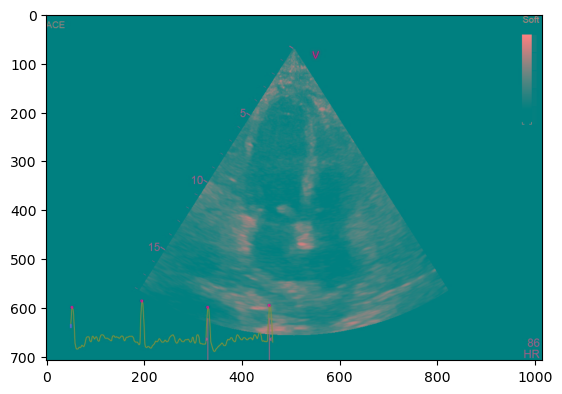

In [38]:
import matplotlib.pyplot as plt
import cv2

frame = dcm.pixel_array[0]
# frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
plt.imshow(frame, cmap='gray')

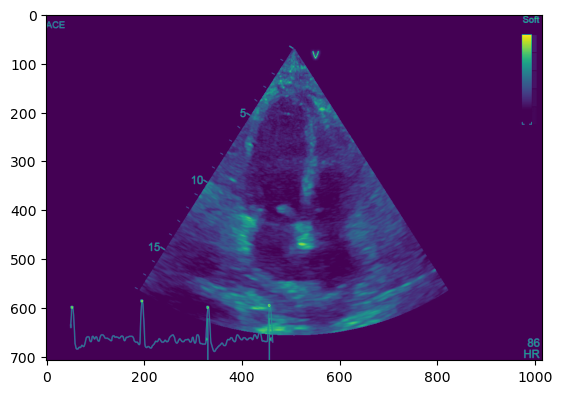

In [39]:
f_1 = frame[:,:,0]
plt.imshow(f_1)

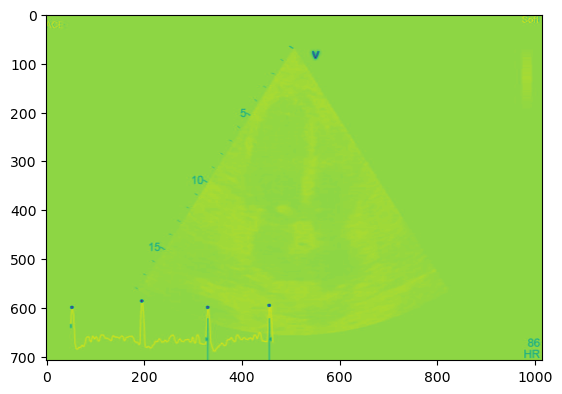

In [40]:
f_2 = frame[:,:,1]
plt.imshow(f_2)

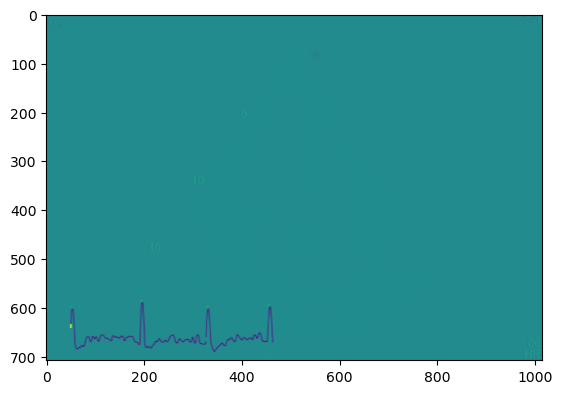

In [41]:
f_3 = frame[:,:,2]
plt.imshow(f_3)